<a href="https://colab.research.google.com/github/jmassery/mask_detector/blob/main/computer_vision_mask_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask Detector

This notebook aims to determine whether or not an individual is wearing a face mask.

## Problem Definition
Given images of faces, determine whether or not the individual in the image is masked.

## Features

## Preparing the tools

In [ ]:
# Data analysis and wrangling
import os
import zipfile
import pathlib
import datetime
import pandas as pd
import numpy as np

# Visualization
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Modelling
import tensorflow as tf

In [ ]:
!wget 'https://data-flair.s3.ap-south-1.amazonaws.com/Data-Science-Data/face-mask-dataset.zip'

--2021-09-15 16:20:27--  https://data-flair.s3.ap-south-1.amazonaws.com/Data-Science-Data/face-mask-dataset.zip
Resolving data-flair.s3.ap-south-1.amazonaws.com (data-flair.s3.ap-south-1.amazonaws.com)... 52.219.160.2
Connecting to data-flair.s3.ap-south-1.amazonaws.com (data-flair.s3.ap-south-1.amazonaws.com)|52.219.160.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76808601 (73M) [application/zip]
Saving to: ‘face-mask-dataset.zip’

face-mask-dataset.z 100%[===================>]  73.25M  11.5MB/s    in 8.1s    

2021-09-15 16:20:37 (9.00 MB/s) - ‘face-mask-dataset.zip’ saved [76808601/76808601]



In [ ]:
# Unzip the data
zip_file = zipfile.ZipFile('face-mask-dataset.zip', 'r')
zip_file.extractall()
zip_file.close()

In [ ]:
pathlist = pathlib.Path('/content/Dataset').glob('**/*.zip')
for path in pathlist:
     zip_file = zipfile.ZipFile(str(path), 'r')
     zip_file.extractall()
     zip_file.close()    

In [ ]:
!mkdir data
!mv /content/test /content/data
!mv /content/train /content/data

In [ ]:
# Walkthrough directories
for dirpath, dirnames, filenames in os.walk('/content/data'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in /content/data
There are 2 directories and 0 images in /content/data/train
There are 0 directories and 658 images in /content/data/train/with_mask
There are 0 directories and 657 images in /content/data/train/without_mask
There are 2 directories and 0 images in /content/data/test
There are 0 directories and 97 images in /content/data/test/with_mask
There are 0 directories and 97 images in /content/data/test/without_mask


In [ ]:
# Get class names from folder names
train_dir = pathlib.Path('/content/data/train')
class_names = np.array(sorted([item.name for item in train_dir.glob('*')]))
print(class_names)

['with_mask' 'without_mask']


## Visualize

In [ ]:
def view_random_image(target_dir, target_class):
  """
  Returns and plots a random image from the target directory based on the target class
  """
  # Get a random image
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in and plot image
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}")

  return img

Image shape: (428, 320, 3)


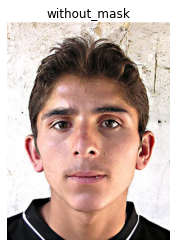

In [ ]:
img = view_random_image(target_dir='/content/data/test/', target_class='without_mask')

In [ ]:
img

array([[[255, 245, 255],
        [253, 244, 247],
        [255, 247, 244],
        ...,
        [251, 245, 231],
        [250, 244, 232],
        [245, 239, 227]],

       [[244, 233, 239],
        [243, 233, 234],
        [241, 234, 228],
        ...,
        [225, 216, 199],
        [224, 215, 200],
        [220, 211, 196]],

       [[251, 241, 239],
        [252, 243, 238],
        [244, 235, 230],
        ...,
        [227, 212, 191],
        [224, 209, 190],
        [225, 209, 193]],

       ...,

       [[  0,   0,   2],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  2,   0,   1]],

       [[  1,   1,   3],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  2,   0,   1]],

       [[  1,   1,   3],
        [  1,   1,   1],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  2,   0,   1]]

## Preprocess and Prepare Data

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Preprocess data 
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Setup directories
train_dir = '/content/data/train'
test_dir = '/content/data/test'

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir, 
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               seed=42)

valid_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224,224),
                                             class_mode='binary',
                                             seed=42)

Found 1315 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


## Modelling Experiments
* Model 0: 2D Convolutional Neural Network
* Model 1: Feed-forward Neural Network
* Model 2: Same as Model 1 but more complex
* Model 3: Same as Model 0 but with augmented data

## Helper Functions

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

### Model 0

In [ ]:
from gc import callbacks
# Build
model_0 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation='relu',
                         input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid')
], name='model_0')

# Compile
model_0.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit
history_0 = model_0.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=[create_model_checkpoint(model_0.name)])

Epoch 1/5
42/42 [==============================] - 26s 236ms/step - loss: 0.3802 - accuracy: 0.8555 - val_loss: 0.1462 - val_accuracy: 0.9485
INFO:tensorflow:Assets written to: model_experiments/model_0/assets
Epoch 2/5
42/42 [==============================] - 10s 235ms/step - loss: 0.1558 - accuracy: 0.9490 - val_loss: 0.2685 - val_accuracy: 0.8969
Epoch 3/5
42/42 [==============================] - 10s 226ms/step - loss: 0.1375 - accuracy: 0.9498 - val_loss: 0.1698 - val_accuracy: 0.9381
Epoch 4/5
42/42 [==============================] - 10s 254ms/step - loss: 0.0838 - accuracy: 0.9719 - val_loss: 0.1166 - val_accuracy: 0.9639
INFO:tensorflow:Assets written to: model_experiments/model_0/assets
Epoch 5/5
42/42 [==============================] - 9s 225ms/step - loss: 0.0855 - accuracy: 0.9726 - val_loss: 0.1937 - val_accuracy: 0.9433


In [ ]:
model_0 = tf.keras.models.load_model('model_experiments/model_0')
model_0.summary()

Model: "model_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0   

In [ ]:
model_0.evaluate(valid_data)

7/7 [==============================] - 1s 109ms/step - loss: 0.1166 - accuracy: 0.9639


[0.11663303524255753, 0.9639175534248352]

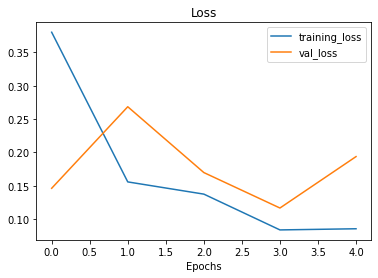

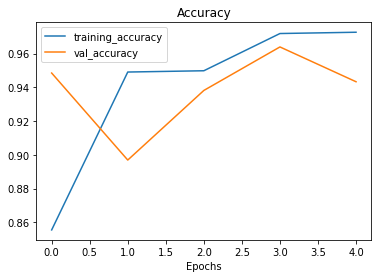

In [ ]:
plot_loss_curves(history_0)

### Model 1

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Build
model_1 = tf.keras.Sequential([
  # flatten to 1d vector for Dense layer 
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')                             
], name='model_1')

# Compile
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=[create_model_checkpoint(model_1.name)])

Epoch 1/5
42/42 [==============================] - 9s 209ms/step - loss: 1.9340 - accuracy: 0.4722 - val_loss: 0.6932 - val_accuracy: 0.5000
INFO:tensorflow:Assets written to: model_experiments/model_1/assets
Epoch 2/5
42/42 [==============================] - 8s 199ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5000
INFO:tensorflow:Assets written to: model_experiments/model_1/assets
Epoch 3/5
42/42 [==============================] - 8s 187ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
42/42 [==============================] - 8s 202ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5000
INFO:tensorflow:Assets written to: model_experiments/model_1/assets
Epoch 5/5
42/42 [==============================] - 8s 200ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5000
INFO:tensorflow:Assets written to: model_experiments/model_1/assets


In [ ]:
model_1 = tf.keras.models.load_model('model_experiments/model_1')
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 602116    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


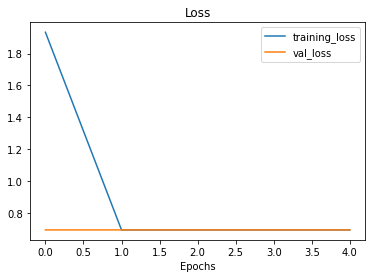

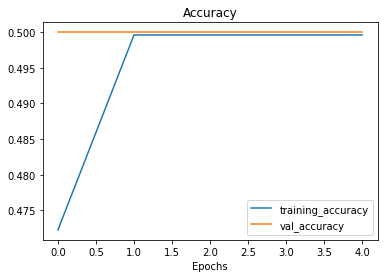

In [ ]:
plot_loss_curves(history_1)

### Model 2

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Build a model similar to Model 1 but with more neurons and an extra layer
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')                             
], name='model_2')

# Compile
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=[create_model_checkpoint(model_2.name)])

Epoch 1/5
42/42 [==============================] - 10s 213ms/step - loss: 4.3534 - accuracy: 0.5954 - val_loss: 2.4757 - val_accuracy: 0.5464
INFO:tensorflow:Assets written to: model_experiments/model_2/assets
Epoch 2/5
42/42 [==============================] - 9s 209ms/step - loss: 1.5407 - accuracy: 0.7354 - val_loss: 0.6976 - val_accuracy: 0.8093
INFO:tensorflow:Assets written to: model_experiments/model_2/assets
Epoch 3/5
42/42 [==============================] - 9s 204ms/step - loss: 0.8140 - accuracy: 0.7916 - val_loss: 0.4975 - val_accuracy: 0.8814
INFO:tensorflow:Assets written to: model_experiments/model_2/assets
Epoch 4/5
42/42 [==============================] - 9s 203ms/step - loss: 0.2708 - accuracy: 0.9011 - val_loss: 0.2752 - val_accuracy: 0.9072
INFO:tensorflow:Assets written to: model_experiments/model_2/assets
Epoch 5/5
42/42 [==============================] - 8s 202ms/step - loss: 0.3160 - accuracy: 0.8951 - val_loss: 1.0727 - val_accuracy: 0.7577


In [ ]:
model_2 = tf.keras.models.load_model('model_experiments/model_2')
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15052900  
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


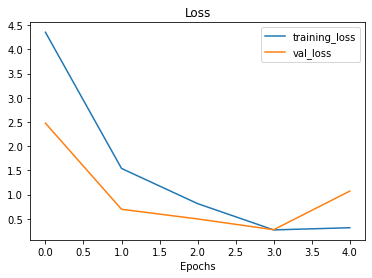

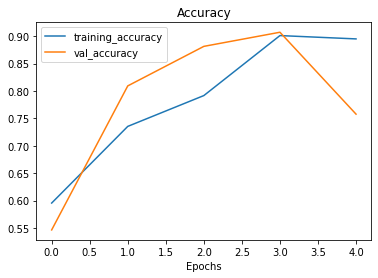

In [ ]:
plot_loss_curves(history_2)

### Model 3

In [ ]:
# Create augmented data
train_datagen_augmented = ImageDataGenerator(rescale=1./255,
                                             rotation_range=20,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir, 
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=True)

Found 1315 images belonging to 2 classes.


In [ ]:
# Check augmented images
augmented_images, augmented_labels = train_data_augmented.next()

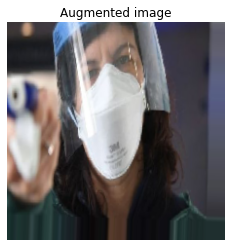

In [ ]:
# Show original image and augmented image
random_number = random.randint(0, 32)
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [ ]:
# Build
model_3 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation='relu',
                         input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid')
], name='model_3')

# Compile
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit
history_3 = model_3.fit(train_data_augmented,
                        epochs=45,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=[create_model_checkpoint(model_3.name)])

Epoch 1/45
42/42 [==============================] - 24s 548ms/step - loss: 0.6667 - accuracy: 0.5848 - val_loss: 0.4638 - val_accuracy: 0.8608
INFO:tensorflow:Assets written to: model_experiments/model_3/assets
Epoch 2/45
42/42 [==============================] - 23s 542ms/step - loss: 0.3970 - accuracy: 0.8357 - val_loss: 0.1388 - val_accuracy: 0.9639
INFO:tensorflow:Assets written to: model_experiments/model_3/assets
Epoch 3/45
42/42 [==============================] - 23s 545ms/step - loss: 0.2935 - accuracy: 0.8966 - val_loss: 0.1701 - val_accuracy: 0.9278
Epoch 4/45
42/42 [==============================] - 23s 544ms/step - loss: 0.3025 - accuracy: 0.8935 - val_loss: 0.0918 - val_accuracy: 0.9845
INFO:tensorflow:Assets written to: model_experiments/model_3/assets
Epoch 5/45
42/42 [==============================] - 23s 544ms/step - loss: 0.2156 - accuracy: 0.9202 - val_loss: 0.0602 - val_accuracy: 0.9897
INFO:tensorflow:Assets written to: model_experiments/model_3/assets
Epoch 6/45
42

In [ ]:
model_3 = tf.keras.models.load_model('model_experiments/model_3')
model_3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 28090)             0   

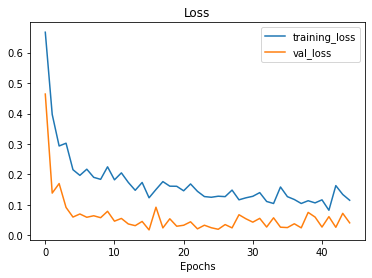

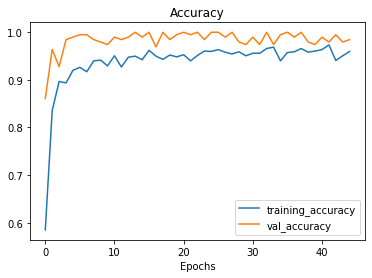

In [ ]:
plot_loss_curves(history_3)

## Predictions

predicting on custom data

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, color_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 color channels 
  img = tf.image.decode_image(img, channels=3)

  # Resize and rescale the image
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.
  
  return img

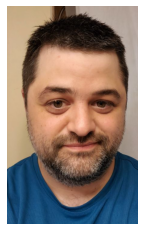

In [ ]:
# View custom image
custom = mpimg.imread('/content/Close up.JPG')
plt.imshow(custom)
plt.axis(False);

In [ ]:
custom.shape

(723, 434, 3)

In [ ]:
custom = load_and_prep_image('/content/rose_masked.jpg')
custom

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.48977593, 0.5133053 , 0.46120447],
        [0.4959384 , 0.5194678 , 0.46736696],
        [0.48949578, 0.5130252 , 0.46092436],
        ...,
        [0.46414563, 0.42885152, 0.36218485],
        [0.46022406, 0.42492995, 0.35826328],
        [0.46022406, 0.42492995, 0.35826328]],

       [[0.63529414, 0.6394958 , 0.5848739 ],
        [0.5452381 , 0.5494398 , 0.49467784],
        [0.5561625 , 0.5603641 , 0.50182074],
        ...,
        [0.4630252 , 0.4277311 , 0.3610644 ],
        [0.45910364, 0.42380953, 0.35714284],
        [0.45910364, 0.42380953, 0.35714284]],

       [[0.70238096, 0.6784314 , 0.6156863 ],
        [0.6497199 , 0.6257703 , 0.5630252 ],
        [0.63347334, 0.6114846 , 0.5420168 ],
        ...,
        [0.46036416, 0.42507005, 0.35840338],
        [0.45924369, 0.42394957, 0.3572829 ],
        [0.45966387, 0.42436975, 0.3577031 ]],

       ...,

       [[0.30896354, 0.3560224 , 0.11288512],
        [0.30

In [ ]:
# Add an extra axis (for batch size)
custom = tf.expand_dims(custom, axis=0)
custom.shape

TensorShape([1, 224, 224, 3])

In [ ]:
custom

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.48977593, 0.5133053 , 0.46120447],
         [0.4959384 , 0.5194678 , 0.46736696],
         [0.48949578, 0.5130252 , 0.46092436],
         ...,
         [0.46414563, 0.42885152, 0.36218485],
         [0.46022406, 0.42492995, 0.35826328],
         [0.46022406, 0.42492995, 0.35826328]],

        [[0.63529414, 0.6394958 , 0.5848739 ],
         [0.5452381 , 0.5494398 , 0.49467784],
         [0.5561625 , 0.5603641 , 0.50182074],
         ...,
         [0.4630252 , 0.4277311 , 0.3610644 ],
         [0.45910364, 0.42380953, 0.35714284],
         [0.45910364, 0.42380953, 0.35714284]],

        [[0.70238096, 0.6784314 , 0.6156863 ],
         [0.6497199 , 0.6257703 , 0.5630252 ],
         [0.63347334, 0.6114846 , 0.5420168 ],
         ...,
         [0.46036416, 0.42507005, 0.35840338],
         [0.45924369, 0.42394957, 0.3572829 ],
         [0.45966387, 0.42436975, 0.3577031 ]],

        ...,

        [[0.30896354, 0.3560224 , 

In [ ]:
# Predict on custom image tensor
pred_prob = model_3.predict(custom)
pred_prob

array([[0.96184623]], dtype=float32)

In [ ]:
pred_class = class_names[int(tf.round(pred_prob)[0][0])]
pred_class

'without_mask'

In [ ]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

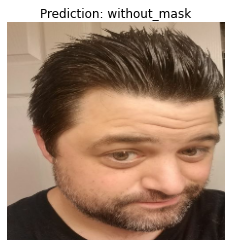

In [ ]:
pred_and_plot(model_2, '/content/Close up 2.JPG', class_names)